# Robot Arm Trajectory Evolutionary Engine

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import LIF
from snntorch import functional

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
from numpy import load

import sys
import os
sys.path.append(os.path.relpath("robot_trajectories.py"))

from robot_trajectories import RobotTrajectories

from warnings import warn
from snntorch.surrogate import atan

import pandas as pd
from copy import deepcopy
import random
import seaborn as sns

### Robot Arm Trajectory Dataset

In [ ]:
class RobotDataset(Dataset):
    def __init__(self, generator, n_samples):
        self.data = generator.generate_data(n_samples)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Training Parameters 
seq_length = 30
n_batch = 50
n_periods= 1   
dt = 0.01
dt_step = dt/1000
n_samples = 1000
    
robot_data = RobotTrajectories(1, seq_length, n_periods, dt_step)
robot_dataset = RobotDataset(robot_data, n_samples)

dataloader = DataLoader(robot_dataset, batch_size=n_batch, shuffle=True, num_workers=0, drop_last=True)

# extract values from each trial in batch
for i, batch in enumerate(dataloader):
    omega0, omega1, x, y = batch

In [ ]:
# for visualizing sample trials of the x and y trajectory of the robot arm dataset
def plot_dataset_samples_scatter(dataloader, num_samples=5):
    fig, axs = plt.subplots(num_samples, 1, figsize=(10, num_samples * 5))
    
    for i, (omega0, omega1, x, y) in enumerate(dataloader):
        if i >= num_samples:
            break
        
        # Convert tensors to numpy for plotting
        x_seq = x[i, 0].detach().cpu().numpy()
        y_seq = y[i, 0].detach().cpu().numpy()

        # Scatter plot of x and y values
        axs[i].plot(range(len(x_seq)), x_seq, label='x', alpha=0.6)
        axs[i].plot(range(len(y_seq)), y_seq, label='y', alpha=0.6)
        axs[i].set_title(f'Sample {i} - x and y values')
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_dataset_samples_scatter(dataloader)

### Synchrony, Criticality Measures

In [5]:
def synchronity(num_steps, spikes):
    van_rossum_distance = 0
    for step in range(1,num_steps):
        differences = spikes[step] - spikes[step - 1]
        squared_differences = differences ** 2
        van_rossum_distance += torch.sum(squared_differences).item()
    return van_rossum_distance

def simple_branching_param(bin_size, spikes):  # spikes in shape of [units, time]
    # run_time = spikes.shape[1]
    nbins = spikes.shape[1]
    # nbins = int(np.round(run_time / bin_size))

    # for every pair of timesteps, determine the number of ancestors
    # and the number of descendants
    numA = torch.zeros(nbins - 1)
    # number of ancestors for each bin
    numD = torch.zeros(nbins - 1)
    # number of descendants for each ancestral bin
    i = 0
    while i < (numA.size(0) - 1):
        numA[i] = torch.sum(spikes[:, i] == 1).item()
        numD[i] = torch.sum(spikes[:, i + bin_size] == 1).item()
        
        # Check if numA[i] is 0, and remove numA[i] and numD[i] if it is
        if numA[i] == 0:
            numA = torch.cat((numA[:i], numA[i+1:]))
            numD = torch.cat((numD[:i], numD[i+1:]))
        else:
            i+=1
            
    # the ratio of descendants per ancestor
    d = numD / numA

    # if we get a nan, that means there were no ancestors in the
    # previous time point;
    # in that case it probably means our choice of bin size is wrong
    # but to handle it for now we should probably just disregard
    # if we get a 0, that means there were no descendants in the next
    # time point;
    # 0 in that case is correct, because branching 'dies'
    # however, that's also incorrect because it means we are choosing
    # our bin size wrong for actual synaptic effects!
    # will revisit this according to time constants
    bscore = torch.nanmean(d)
    # bscore = bscore().clone().detach().requires_grad_(True)
    return bscore

# Synchrony -- Fano Factor
def fano_factor(seq_len, spike):
    # Calculate value similar to the Fano factor to estimate synchrony quickly
    # During each bin, calculate the variance of the number of spikes per neuron divided by the mean of the number of spikes per neuron
    # The Fano factor during one interval is equal to the mean of the values calculated for each bin in it
    # Spike should have dims of neuron, time
    # Returned fano factor should have dims of trial
    len_bins = 10  # ms
    n_bins = int(round(seq_len / len_bins))
    fano_all = torch.zeros(n_bins)
    for i in range(n_bins):
        spike_slice = spike[:, i * len_bins:(i + 1) * len_bins]
        spikes_per_neuron = torch.sum(spike_slice, axis=1)
        variance_spikes = torch.var(spikes_per_neuron)
        mean_spikes = torch.mean(spikes_per_neuron)
        fano_bin = variance_spikes / mean_spikes if mean_spikes != 0 else 0
        fano_all[i] = fano_bin
    n_fano = torch.nanmean(fano_all)
    return n_fano


### Building Connectivity and Neurons

In [6]:
# creates connection matrix with specific sparseness for linear layers
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

# creates an excitatory and inhibitory matrix for recurrent layer
def hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn):

    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Excitatory connections

    # excitatory to excitatory
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-p_nn['e_e'], p_nn['e_e']])
    # excitatory to inhibitory PV
    weight_matrix[:num_excitatory, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, 1], size=(num_excitatory, num_iPV), p=[1-p_nn['e_PV'], p_nn['e_PV']])
    # excitatory to inhibitory Sst
    weight_matrix[:num_excitatory, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, 1], size=(num_excitatory, num_iSst), p=[1-p_nn['e_Sst'], p_nn['e_Sst']])
    # excitatory to inhibitory Htr
    weight_matrix[:num_excitatory, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, 1], size=(num_excitatory, num_iHtr), p=[1-p_nn['e_Htr'], p_nn['e_Htr']])


    # Inhibitory connections

    # inhibitory PV to excitatory
    weight_matrix[num_excitatory:num_excitatory+num_iPV, :num_excitatory] = np.random.choice([0, -1], size=(num_iPV, num_excitatory), p=[1-p_nn['PV_e'], p_nn['PV_e']])
    # inhibitory PV to inhibitory PV
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iPV, num_iPV), p=[1-p_nn['PV_PV'], p_nn['PV_PV']])
    # inhibitory PV to inhibitory Htr
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iPV, num_iSst), p=[1-p_nn['PV_Sst'], p_nn['PV_Sst']])
    # inhibitory PV to inhibitory Sst
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iPV, num_iHtr), p=[1-p_nn['PV_Htr'], p_nn['PV_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, :num_excitatory] = np.random.choice([0, -1], size=(num_iSst, num_excitatory), p=[1-p_nn['Sst_e'], p_nn['Sst_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iSst, num_iPV), p=[1-p_nn['Sst_PV'], p_nn['Sst_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iSst, num_iSst), p=[1-p_nn['Sst_Sst'], p_nn['Sst_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iSst, num_iHtr), p=[1-p_nn['Sst_Htr'], p_nn['Sst_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV+num_iSst:, :num_excitatory] = np.random.choice([0, -1], size=(num_iHtr, num_excitatory), p=[1-p_nn['Htr_e'], p_nn['Htr_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iHtr, num_iPV), p=[1-p_nn['Htr_PV'], p_nn['Htr_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iHtr, num_iSst), p=[1-p_nn['Htr_Sst'], p_nn['Htr_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iHtr, num_iHtr), p=[1-p_nn['Htr_Htr'], p_nn['Htr_Htr']]) 


    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

In [ ]:
# leaky integrate-and-fire neuron with recurrent connections from snn torch with refractory period
class RLIF1(LIF):
    def __init__(
        self,
        beta,
        V=1.0,
        all_to_all=True,
        linear_features=None,
        conv2d_channels=None,
        kernel_size=None,
        threshold= -55.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        learn_recurrent=True,  # changed learn_V
        reset_mechanism="zero",
        state_quant=False,
        output=False,
        reset_delay=True,
        refractory_period=1.0,  # in milliseconds
    ):
        super().__init__(
            beta,
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_beta,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
        )

        self.all_to_all = all_to_all
        self.learn_recurrent = learn_recurrent

        # linear params
        self.linear_features = linear_features

        # Conv2d params
        self.kernel_size = kernel_size
        self.conv2d_channels = conv2d_channels

        # catch cases
        self._rleaky_init_cases()

        # initialize recurrent connections
        if self.all_to_all:  # init all-all connections
            self._init_recurrent_net()
        else:  # initialize 1-1 connections
            self._V_register_buffer(V, learn_recurrent)
            self._init_recurrent_one_to_one()

        if not learn_recurrent:
            self._disable_recurrent_grad()

        self._init_mem()

        if self.reset_mechanism_val == 0:  # reset by subtraction
            self.state_function = self._base_sub
        elif self.reset_mechanism_val == 1:  # reset to zero
            self.state_function = self._base_zero
        elif self.reset_mechanism_val == 2:  # no reset, pure integration
            self.state_function = self._base_int

        self.reset_delay = reset_delay

        # Refractory period in timesteps
        self.refractory_period = refractory_period

    def _init_mem(self):
        #initialize spike, membrane, and refractory counter
        spk = torch.zeros(0)
        mem = torch.zeros(0)
        refractory_counter = torch.zeros(0)

        self.register_buffer("spk", spk, False)
        self.register_buffer("mem", mem, False)
        #persistent=False, you are indicating that refractory_counter is an intermediate state that should not be included in the model's state_dic
        self.register_buffer("refractory_counter", refractory_counter, persistent=False)

    def reset_mem(self):
        self.spk = torch.zeros_like(self.spk, device=self.spk.device)
        self.mem = torch.zeros_like(self.mem, device=self.mem.device)
        self.refractory_counter = torch.zeros_like(self.refractory_counter, device=self.refractory_counter.device)
        return self.spk, self.mem

    def init_rleaky(self):
        """Deprecated, use :class:`RLeaky.reset_mem` instead"""
        return self.reset_mem()

    def forward(self, input_, spk=None, mem=None, refractory_counter=None):
        if not spk is None:
            self.spk = spk

        if not mem is None:
            self.mem = mem

        if not refractory_counter is None:
            self.refractory_counter = refractory_counter

        if self.init_hidden and (not mem is None or not spk is None or not refractory_counter is None):
            raise TypeError(
                "When `init_hidden=True`, RLeaky expects 1 input argument."
            )

        if not self.spk.shape == input_.shape:
            self.spk = torch.zeros_like(input_, device=self.spk.device)

        if not self.mem.shape == input_.shape:
            self.mem = torch.zeros_like(input_, device=self.mem.device)

        if not self.refractory_counter.shape == input_.shape:
            self.refractory_counter = torch.zeros_like(input_, device=self.refractory_counter.device)

        # With each forward, decrement the counter
        self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)

        # Update the membrane potential
        self.reset = self.mem_reset(self.mem)
        self.mem = self.state_function(input_)

        # set a spike on when refractory period is 0
        refractory_mask = (self.refractory_counter == 0)
        self.spk = self.fire(self.mem) * refractory_mask

        # Update the refractory counter back to 5 where spikes occurred
        self.refractory_counter[self.spk > 0] = self.refractory_period

        if not self.reset_delay:
            do_reset = (
                self.spk / self.graded_spikes_factor - self.reset
            )  # avoid double reset
            if self.reset_mechanism_val == 0:  # reset by subtraction
                self.mem = self.mem - do_reset * self.threshold
            elif self.reset_mechanism_val == 1:  # reset to zero
                self.mem = self.mem - do_reset * self.mem

        if self.output:
            return self.spk, self.mem
        elif self.init_hidden:
            return self.spk
        else:
            return self.spk, self.mem

    def _init_recurrent_net(self):
        if self.all_to_all:
            if self.linear_features:
                self._init_recurrent_linear()
            elif self.kernel_size is not None:
                self._init_recurrent_conv2d()
        else:
            self._init_recurrent_one_to_one()

    def _init_recurrent_linear(self):
        self.recurrent = nn.Linear(self.linear_features, self.linear_features)

    def _init_recurrent_conv2d(self):
        self._init_padding()
        self.recurrent = nn.Conv2d(
            in_channels=self.conv2d_channels,
            out_channels=self.conv2d_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
        )

    def _init_padding(self):
        if type(self.kernel_size) is int:
            self.padding = self.kernel_size // 2, self.kernel_size // 2
        else:
            self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2

    def _init_recurrent_one_to_one(self):
        self.recurrent = RecurrentOneToOne(self.V)

    def _disable_recurrent_grad(self):
        for param in self.recurrent.parameters():
            param.requires_grad = False

    def _base_state_function(self, input_):
        base_fn = (
            self.beta.clamp(0, 1) * self.mem
            + input_
            + self.recurrent(self.spk)
        )
        return base_fn

    def _base_sub(self, input_):
        return self._base_state_function(input_) - self.reset * self.threshold

    def _base_zero(self, input_):
        return self._base_state_function(input_) - self.reset * (self.mem + 70)

    def _base_int(self, input_):
        return self._base_state_function(input_)

    def _rleaky_init_cases(self):
        all_to_all_bool = bool(self.all_to_all)
        linear_features_bool = self.linear_features
        conv2d_channels_bool = bool(self.conv2d_channels)
        kernel_size_bool = bool(self.kernel_size)

        if all_to_all_bool:
            if not (linear_features_bool):
                if not (conv2d_channels_bool or kernel_size_bool):
                    raise TypeError(
                        "When `all_to_all=True`, RLeaky requires either"
                        "`linear_features` or (`conv2d_channels` and "
                        "`kernel_size`) to be specified. The "
                        "shape should match the shape of the output spike of "
                        "the layer."
                    )
                elif conv2d_channels_bool ^ kernel_size_bool:
                    raise TypeError(
                        "`conv2d_channels` and `kernel_size` must both be"
                        "specified. The shape of `conv2d_channels` should "
                        "match the shape of the output"
                        "spikes."
                    )
            elif (linear_features_bool and kernel_size_bool) or (
                linear_features_bool and conv2d_channels_bool
            ):
                raise TypeError(
                    "`linear_features` cannot be specified at the same time as"
                    "`conv2d_channels` or `kernel_size`. A linear layer and "
                    "conv2d layer cannot both"
                    "be specified at the same time."
                )
        else:
            if (
                linear_features_bool
                or conv2d_channels_bool
                or kernel_size_bool
            ):
                raise TypeError(
                    "When `all_to_all`=False, none of `linear_features`,"
                    "`conv2d_channels`, or `kernel_size` should be specified. "
                    "The weight `V` is used"
                    "instead."
                )

    @classmethod
    def detach_hidden(cls):
        """Returns the hidden states, detached from the current graph.
        Intended
        for use in truncated backpropagation through time where hidden state
        variables
        are instance variables."""

        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                cls.instances[layer].mem.detach_()
                cls.instances[layer].spk.detach_()

    @classmethod
    def reset_hidden(cls):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are instance variables.
        Assumes hidden states have a batch dimension already."""
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                (
                    cls.instances[layer].spk,
                    cls.instances[layer].mem,
                ) = cls.instances[layer].init_rleaky()

### Defining the Network

In [9]:
# RSNN model with 2 input neurons, 256 hidden neurons, and 2 output neurons, with 3 inhibitory neuron classes
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()
        num_inputs = 2
        num_hidden = 256
        num_output = 2
        pe_e = 0.16

        # Dictionary with probabilities of connection between each neuron type 
        p_nn = {'e_e': 0.16, 'e_PV': 0.395, 'e_Sst': 0.182, 'e_Htr': 0.105,
                'PV_e': 0.411, 'PV_PV': 0.451, 'PV_Sst': 0.03, 'PV_Htr': 0.22,
                'Sst_e': 0.424, 'Sst_PV': 0.857, 'Sst_Sst': 0.082, 'Sst_Htr': 0.77,
                'Htr_e': 0.087, 'Htr_PV': 0.02, 'Htr_Sst': 0.0625, 'Htr_Htr': 0.028
                } 

        self.p_nn = p_nn
        
        # Define the dimensions
        num_excitatory = round(0.85 * num_hidden) # 85% : 15% Excitatory to inhibitory
        self.num_excitatory = num_excitatory
        num_inhibitory = num_hidden - num_excitatory


       # Three inhibitory neuron classes: 40% PV, 30% Sst, 30% Ht3aR
        num_iPV = round(0.4 * num_inhibitory)
        self.num_iPV = num_iPV
        num_iSst = round(0.3 * num_inhibitory)
        self.num_iSst = num_iSst
        num_iHtr = num_inhibitory - num_iSst - num_iPV
        self.num_iHtr = num_iHtr

        # Three beta values for E, PV, Sst, and Htr3aR
        # Values chosen based on spike triggered adaptation behavior of each class
        beta_e = torch.asarray([0.85] * num_excitatory)
        beta_iPV = torch.asarray([0.7] * num_iPV)   # Little/ no spike frequency adaptation 
        beta_iHtr = torch.asarray([0.6] * num_iHtr)    # Mostly adapting
        beta_iSst = torch.asarray([0.3] * num_iSst)  # Spike frequency adaptation
        beta = torch.cat((beta_e, beta_iPV, beta_iSst, beta_iHtr)) # create array of betas corresponding to each neuron!

        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
      
        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn) 
        self.rlif1 = RLIF1(reset_mechanism='zero', threshold = 1, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        #hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.l2.weight.data = hid_out_mx.T 

          # Store initial sparsity mask
        self.sparse_mask_input = self.l1.weight.data == 0
        self.sparse_mask_recurrent = self.rlif1.recurrent.weight.data == 0
        self.sparse_mask_output = self.l2.weight.data == 0

    def forward(self, omega0, omega1):
        inputs = torch.cat((omega0, omega1), dim=1).float()  # Concatenate along the feature dimension
        inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_inputs)
  
        spk1, mem1 = self.rlif1.init_rleaky()
        
        # Record outputs
        self.spk1_rec = []
        self.cur2_rec = []
        
        # print(inputs.shape)
        for step in range(inputs.size(1)): #100

            cur_input = inputs[:, step, :]
            # cur_input = inputs[step]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec, dim=1)
        self.cur2_rec = torch.stack(self.cur2_rec, dim=1)

        pred_x = self.cur2_rec[:,:,0].unsqueeze(1) #Make sure the pred_x same shape as actual_x
        pred_y = self.cur2_rec[:,:,1].unsqueeze(1) #Make sure the pred_y same shape as actual_y

        return pred_x, pred_y, self.spk1_rec

    
    def positive_negative_weights(self):
        
        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg) 
        self.false_pos.append(num_false_pos) 

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values

In [10]:
def plot_sample_convergence(epoch, pred_x, pred_y, actual_x, actual_y, sample_idx, stage):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Flatten the tensors to compare the entire sequence
    actual_x_seq = actual_x[sample_idx].detach().cpu().numpy()
    pred_x_seq = pred_x[sample_idx].flatten().detach().cpu().numpy()
    actual_y_seq = actual_y[sample_idx].detach().cpu().numpy()
    pred_y_seq = pred_y[sample_idx].flatten().detach().cpu().numpy()

    # Plot x convergence
    axs[0].plot(range(len(actual_x_seq)), actual_x_seq, label='Actual x', alpha=0.6)
    axs[0].plot(range(len(pred_x_seq)), pred_x_seq, label='Predicted x', alpha=0.6)
    axs[0].set_title(f'{stage} - x Convergence (Epoch {epoch+1})')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    # Plot y convergence
    axs[1].plot(range(len(actual_y_seq)), actual_y_seq, label='Actual y', alpha=0.6)
    axs[1].plot(range(len(pred_y_seq)), pred_y_seq, label='Predicted y', alpha=0.6)
    axs[1].set_title(f'{stage} - y Convergence (Epoch {epoch+1})')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [11]:
class CustomLoss(nn.Module):

    def __init__(self, target_synchrony=1.4, target_firing_rate=0.02, target_branching=1.0, batch_size=50):
        super(CustomLoss, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_branching = torch.tensor([target_branching] * batch_size,requires_grad=True)

    def forward(self, pred_x, pred_y, actual_x, actual_y, criticality, firing_rate, synchrony_fano_factor):

        w_crit = 0
        w_rate = 0
        w_sync = 0
        w_mse = 1
        
        mse_loss = nn.MSELoss()(pred_x, actual_x) + nn.MSELoss()(pred_y, actual_y)
        rate_loss = nn.MSELoss()(firing_rate, self.target_firing_rate)
        criticality_loss = nn.MSELoss()(criticality,self.target_branching)
        synchrony_loss = nn.MSELoss()(synchrony_fano_factor,self.target_synchrony)

        self.mse_loss = mse_loss
        self.rate_loss = rate_loss
        self.criticality_loss = criticality_loss
        self.synchrony_loss = synchrony_loss

        self.weighted_mse_loss = w_mse*mse_loss
        self.weighted_rate_loss = w_rate*rate_loss
        self.weighted_criticality_loss =  w_crit*criticality_loss 
        self.weighted_synchrony_loss = w_sync*synchrony_loss

        total_loss = w_mse*mse_loss + w_rate*rate_loss + w_crit*criticality_loss + w_sync*synchrony_loss

        return total_loss

### Evolution

In [12]:
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir('results')

In [21]:
# Genetic Encoding and Decoding

# converts model to gene format by concatenating all the parameters
def encode_model(model):
    gene = []
    for param in model.parameters():
        gene.append(param.data.cpu().numpy().flatten())
    gene = np.concatenate(gene)
    return gene

# decodes gene to model format by reshaping the gene to the original parameter shapes
def decode_model(model, gene):
    current_index = 0
    new_model = deepcopy(model)
    for param in new_model.parameters():
        param_shape = param.data.cpu().numpy().shape
        param_size = np.prod(param_shape)
        param.data = torch.tensor(gene[current_index:current_index + param_size].reshape(param_shape))
        current_index += param_size
    return new_model

In [42]:
def save_encoded_weights(model, filepath):
    encoded_weights = encode_model(model)
    np.savez_compressed(filepath, encoded_weights=encoded_weights)

def load_encoded_weights(model, filepath):
    data = np.load(filepath)
    encoded_weights = data['encoded_weights']
    model = decode_model(model, encoded_weights)
    return model

Generation 1/40, Best Fitness: 59.248371700205524
Overall Best Fitness: 59.248371700205524
Generation 2/40, Best Fitness: 43.24432512098268
Overall Best Fitness: 43.24432512098268
Generation 3/40, Best Fitness: 36.05546029339017
Overall Best Fitness: 36.05546029339017
Generation 4/40, Best Fitness: 32.53378230053192
Overall Best Fitness: 32.53378230053192
Generation 5/40, Best Fitness: 31.62015876225316
Overall Best Fitness: 31.62015876225316
Generation 6/40, Best Fitness: 29.307745715978253
Overall Best Fitness: 29.307745715978253
Generation 7/40, Best Fitness: 28.268534429923722
Overall Best Fitness: 28.268534429923722
Generation 8/40, Best Fitness: 28.71999136272431
Overall Best Fitness: 28.268534429923722
Generation 9/40, Best Fitness: 28.976899978751877
Overall Best Fitness: 28.268534429923722
Generation 10/40, Best Fitness: 28.571469980308102
Overall Best Fitness: 28.268534429923722
Generation 11/40, Best Fitness: 29.311582346617918
Overall Best Fitness: 28.268534429923722
Genera

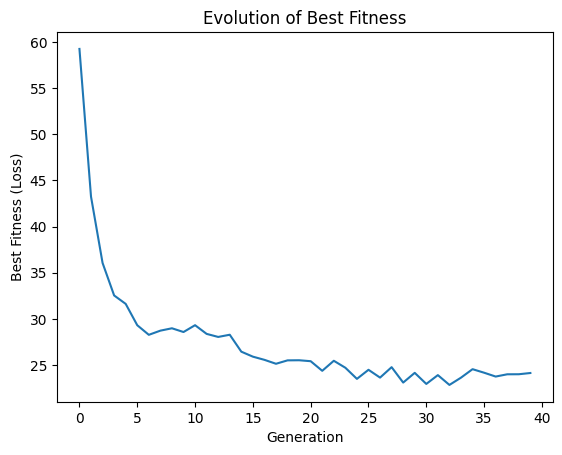

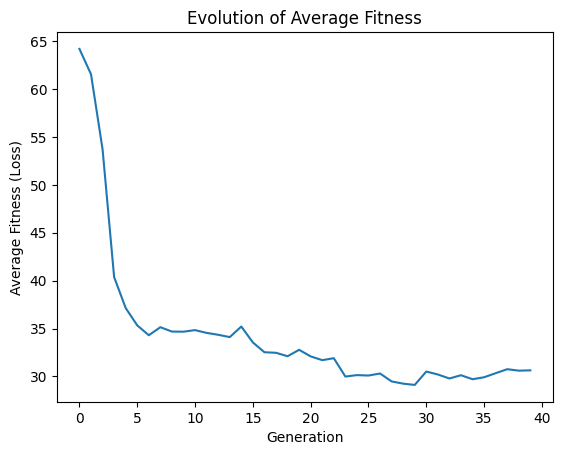

In [18]:
# Main Evolution Class

class Evolution(object):
    def __init__(self, model_class, model_args, model_kwargs):
        # Initialize the model class and its arguments
        self.model_class = model_class
        self.model_args = model_args
        self.model_kwargs = model_kwargs

    # initialize first population of models
    def populate(self, n_models):
        models = []
        for _ in range(n_models):
            model = self.model_class(*self.model_args, **self.model_kwargs)
            self.initialize_weights(model)
            for param in model.parameters():
                param.requires_grad = False
            models.append(model)
        return models

    # initialize weights of the model with three inhibitory neuron classes
    def initialize_weights(self, model):
        num_excitatory = model.num_excitatory
        num_hidden = model.l1.out_features
        num_iPV = model.num_iPV
        num_iSst = model.num_iSst
        num_iHtr = model.num_iHtr
        num_inputs = model.l1.in_features
        num_output = model.l2.out_features
        p_nn = model.p_nn
        num_inhibitory = num_hidden - num_excitatory
        pe_e = 0.16

        # Initialize the input to hidden layer weights
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        model.l1.weight.data = input_hid_mx.T

        # Initialize the recurrent layer weights
        hidden_mx = hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn)
        model.rlif1.recurrent.weight.data = hidden_mx.T

        # Initialize the hidden to output layer weights
        hid_out_mx = conn_mx(num_hidden, num_output, pe_e)
        model.l2.weight.data = hid_out_mx.T

        # Store the initial sparsity mask
        self.weights = model.rlif1.recurrent.weight.data
        self.sparse_mask = torch.where(self.weights == 0, 1, 0)

    # encode the population of models to gene representation
    def encode_population(self, models):
        return [encode_model(model) for model in models]

    # decode the population of models from gene representation
    def decode_population(self, genes, template_model):
        return [decode_model(template_model, gene) for gene in genes]

    # evaluate the models in the population
    def evaluate(self, models, dataloader):
        fitness = []
        for model in models:
            loss = self.evaluate_model(model, dataloader)
            fitness.append(loss)
        return fitness

    # evaluate the model on the robot trajectories dataset
    def evaluate_model(self, model, dataloader):
        criterion = CustomLoss(target_synchrony=1.4, target_firing_rate=0.02, target_branching=1.0)
        running_loss = 0

        model.eval()
        with torch.no_grad():
            for batch_idx, (omega0, omega1, actual_x, actual_y) in enumerate(dataloader):
                pred_x, pred_y, spikes = model(omega0, omega1)
                firing_rate = torch.sum(spikes) / torch.tensor(spikes.numel(), dtype=torch.float)
                synchrony_fano_factor = fano_factor(seq_length, spikes)
                criticality = simple_branching_param(1, spikes)
                loss = criterion(pred_x, pred_y, actual_x, actual_y, criticality, firing_rate, synchrony_fano_factor)
                running_loss += loss.item()
                break
        return running_loss

    # select the top k models based on fitness
    def select(self, genes, fitness, k=2):
        selected_indices = np.argsort(fitness)[:k]
        return [genes[i] for i in selected_indices], [fitness[i] for i in selected_indices]

    # crossover two parents to generate a child
    def crossover(self, parent1, parent2):
        child = deepcopy(parent1)
        crossover_mask = np.random.rand(len(child)) < 0.5
        child[crossover_mask] = parent2[crossover_mask]
        return child

    # mutate the gene of a model with a mutation rate
    def mutate(self, gene, mutation_rate):
        mutation_mask = np.random.rand(len(gene)) < mutation_rate
        gene[mutation_mask] += np.random.randn(np.sum(mutation_mask))

        # EDecode the gene to model format
        model = self.model_class(*self.model_args, **self.model_kwargs)
        decode_model(model, gene) 

        # Reapply the initial sparsity mask
        model_weights = model.rlif1.recurrent.weight.data
        model_weights[self.sparse_mask == True] = 0

        # Split the weights into excitatory and inhibitory
        excitatory_weights = model_weights[:, :model.num_excitatory]
        inhibitory_weights = model_weights[:, model.num_excitatory:]

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        # Ensure no neuron vanishes to enforce dale's law
        self.handle_vanishing_neurons(model, excitatory_weights, inhibitory_weights)  # Assuming handle_vanishing_neurons is a method of the class
        return gene
    
    # enforce dale's law by ensuring no neuron vanishes
    def handle_vanishing_neurons(self, model, excitatory_weights, inhibitory_weights):
        num_excitatory = model.num_excitatory

        mu = -0.64
        sigma = 0.51

        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        excitatory_zero_indices = (model.rlif1.recurrent.weight.data[:, :num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (model.rlif1.recurrent.weight.data[:, num_excitatory:] == 0).nonzero(as_tuple=True)

        if len(excitatory_zero_indices[0]) > num_false_pos:
            excitatory_sampled_indices = torch.stack([
                excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
            ], dim=1)

            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            model.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if len(inhibitory_zero_indices[0]) > num_false_neg:
            inhibitory_sampled_indices = torch.stack([
                inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
            ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            model.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values

    # generate next population of offspring from parents
    def generate_offspring(self, parents, n_offspring, mutation_rate):
        offspring = []
        for _ in range(n_offspring):
            parent1, parent2 = random.sample(parents, 2)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child, mutation_rate)
            offspring.append(child)
        return offspring

    # plot the most fit model's fitness across generations
    def plot_best_fitness(self, all_best_fitness):
        plt.figure()
        plt.plot(all_best_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness (Loss)")
        plt.title("Evolution of Best Fitness")
        plt.show()

    # plot the distribution of fitness across generations as histogram
    def plot_fitness_distribution(self, all_fitness):
        plt.figure()
        for i, fitness in enumerate(all_fitness):
            plt.hist(fitness, bins=30, alpha=0.5, label=f'Gen {i+1}')
        plt.xlabel("Fitness (Loss)")
        plt.ylabel("Frequency")
        plt.title("Fitness Distribution Across Generations")
        plt.legend()
        plt.show()

    # plot the average fitness across generations
    def plot_average_fitness(self, all_fitness):
        average_fitness = [np.mean(fitness) for fitness in all_fitness]
        plt.figure()
        plt.plot(average_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Average Fitness (Loss)")
        plt.title("Evolution of Average Fitness")
        plt.show()

    # run the evolutionary process
    def evolve(self, n_models, n_offspring, n_generations, dataloader, mutation_rate):
        template_model = self.model_class(*self.model_args, **self.model_kwargs)
        # initialize first population of models
        models = self.populate(n_models)
        initial_models = deepcopy(models)
        genes = self.encode_population(models)
        all_genes = []
        all_best_fitness = []
        all_fitness = []
        best_gene_overall = None
        best_fitness_overall = float('inf')
        
        # run the evolution process for n_generations
        for i in range(n_generations):
            all_genes.append(models)
            models = self.decode_population(genes, template_model)
            fitness = self.evaluate(models, dataloader)
            all_fitness.append(fitness)
            parents, parent_fitness = self.select(genes, fitness)
            offspring = self.generate_offspring(parents, n_offspring, mutation_rate)
            genes = parents + offspring
            best_fitness = min(parent_fitness)
            all_best_fitness.append(best_fitness)

            # Update the overall best fitness and gene
            if best_fitness < best_fitness_overall:
                best_fitness_overall = best_fitness
                best_gene_overall = deepcopy(parents[0])
            
    
            print(f"Generation {i+1}/{n_generations}, Best Fitness: {best_fitness}")
            print(f"Overall Best Fitness: {best_fitness_overall}")


        self.plot_best_fitness(all_best_fitness)
        self.plot_average_fitness(all_fitness)
        self.plot_fitness_distribution(all_fitness)

        best_model = self.decode_population([best_gene_overall], template_model)[0]
        final_population = self.decode_population(genes, template_model)

        # np.savez_compressed('evolution_data.npz',
        #                     all_genes=all_genes,
        #                     all_best_fitness=all_best_fitness,
        #                     all_fitness=all_fitness,
        #                     best_gene_overall=best_gene_overall,
        #                     best_fitness_overall=best_fitness_overall)

        # np.savez_compressed('final_population.npz', final_population=final_population)

    
        return best_model, all_best_fitness, final_population, initial_models


In [ ]:
# Define the parameters for the evolutionary process
pop_size = 100
num_generations = 40
n_offspring = 100
mutation_rate = 0.05

# Create the Evolution object and run the evolution process
model = RSNN()
evolution = Evolution(RSNN, (), {})
best_model, fitness, final_population, initial_models = evolution.evolve(pop_size, n_offspring, num_generations, dataloader, mutation_rate)
best_model = deepcopy(best_model)   

# Save the best model's state dictionary
torch.save(best_model.state_dict(), "best_model.pth")

### Plotting

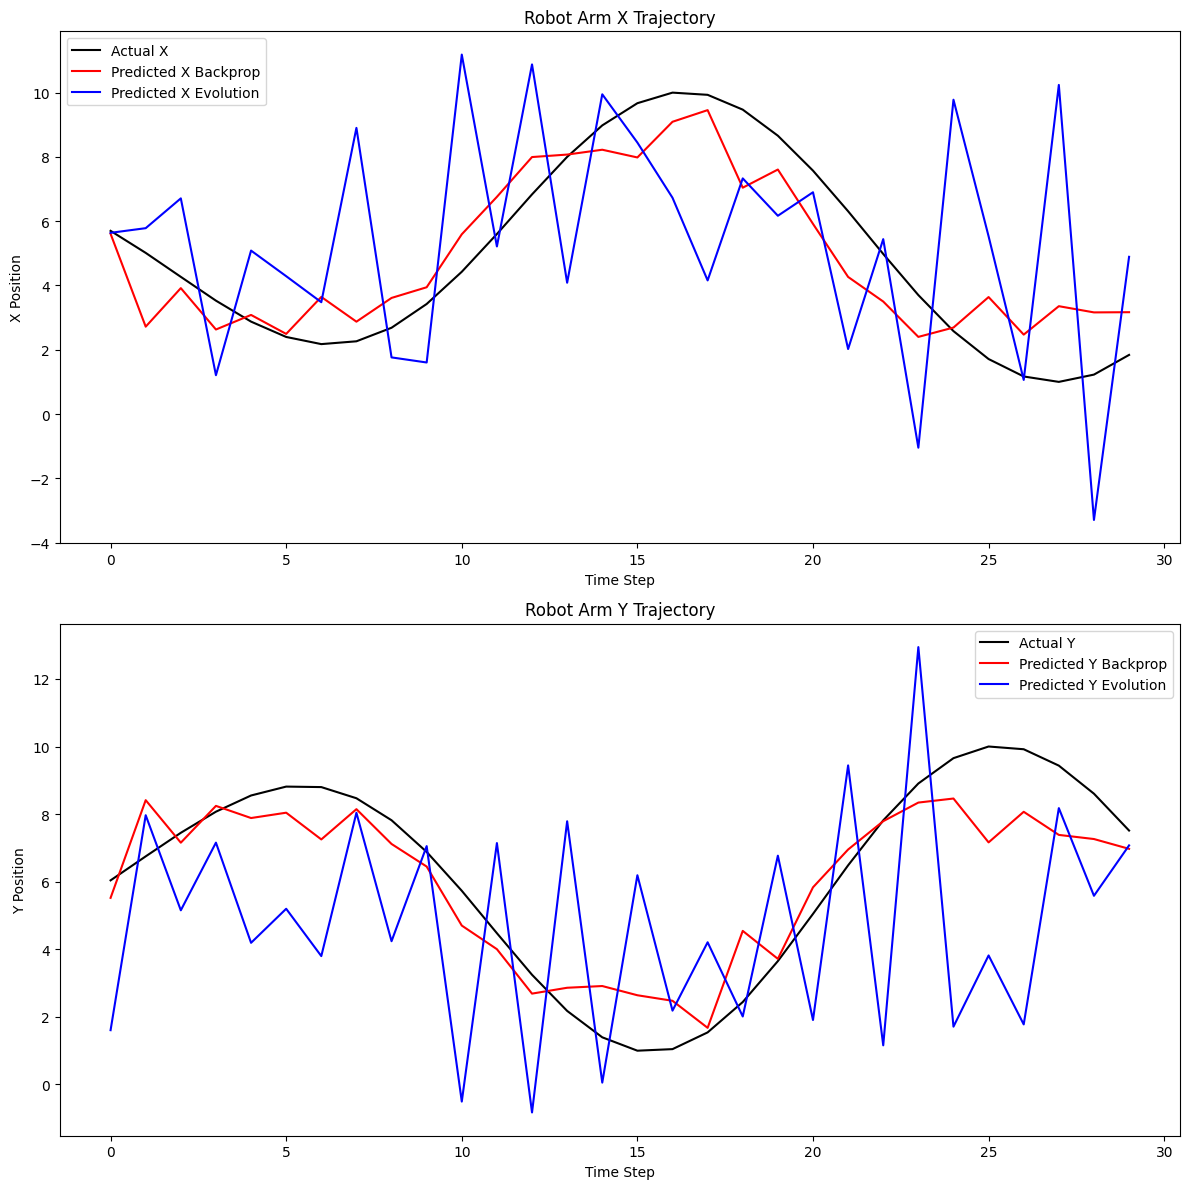

In [19]:
# Plot the trajectories of the best model and final backprop model with corresponding dataloader sample
def plot_trajectories(model_backprop, model_evolution, dataloader):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # Create 2 subplots, one for X and one for Y
    model_backprop.eval()
    model_evolution.eval()
    
    for batch_idx, (omega0, omega1, actual_x, actual_y) in enumerate(dataloader):
        pred_x_backprop, pred_y_backprop, _ = model_backprop(omega0, omega1)
        pred_x_evolution, pred_y_evolution, _ = model_evolution(omega0, omega1)

        x_backprop = pred_x_backprop[1, 0].detach().cpu().numpy()
        y_backprop = pred_y_backprop[1, 0].detach().cpu().numpy()
        x_evolution = pred_x_evolution[1, 0].detach().cpu().numpy()
        y_evolution = pred_y_evolution[1, 0].detach().cpu().numpy()

        break  # Only need the first batch for plotting

    actual_x = actual_x[1,0].flatten().cpu().numpy()
    actual_y= actual_y[1,0].flatten().cpu().numpy()
    
        # Plot x trajectory
    axs[0].plot(range(len(actual_x)), actual_x, label='Actual X', color='black')
    axs[0].plot(range(len(x_backprop)), x_backprop, label='Predicted X Backprop', color='red')
    axs[0].plot(range(len(x_evolution)), x_evolution, label='Predicted X Evolution', color='blue')
    axs[0].set_title('Robot Arm X Trajectory')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('X Position')
    axs[0].legend()

        # Plot y trajectory
    axs[1].plot(range(len(actual_y)), actual_y, label='Actual Y', color='black')
    axs[1].plot(range(len(y_backprop)), y_backprop, label='Predicted Y Backprop', color='red')
    axs[1].plot(range(len(y_evolution)), y_evolution, label='Predicted Y Evolution', color='blue')
    axs[1].set_title('Robot Arm Y Trajectory')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Y Position')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


backprop_model = RSNN()
backprop_model.load_state_dict(torch.load('results/final_backprop_model.pth'))
backprop_model.eval()  # Set the model to evaluation mode


plot_trajectories(backprop_model, best_model, dataloader)


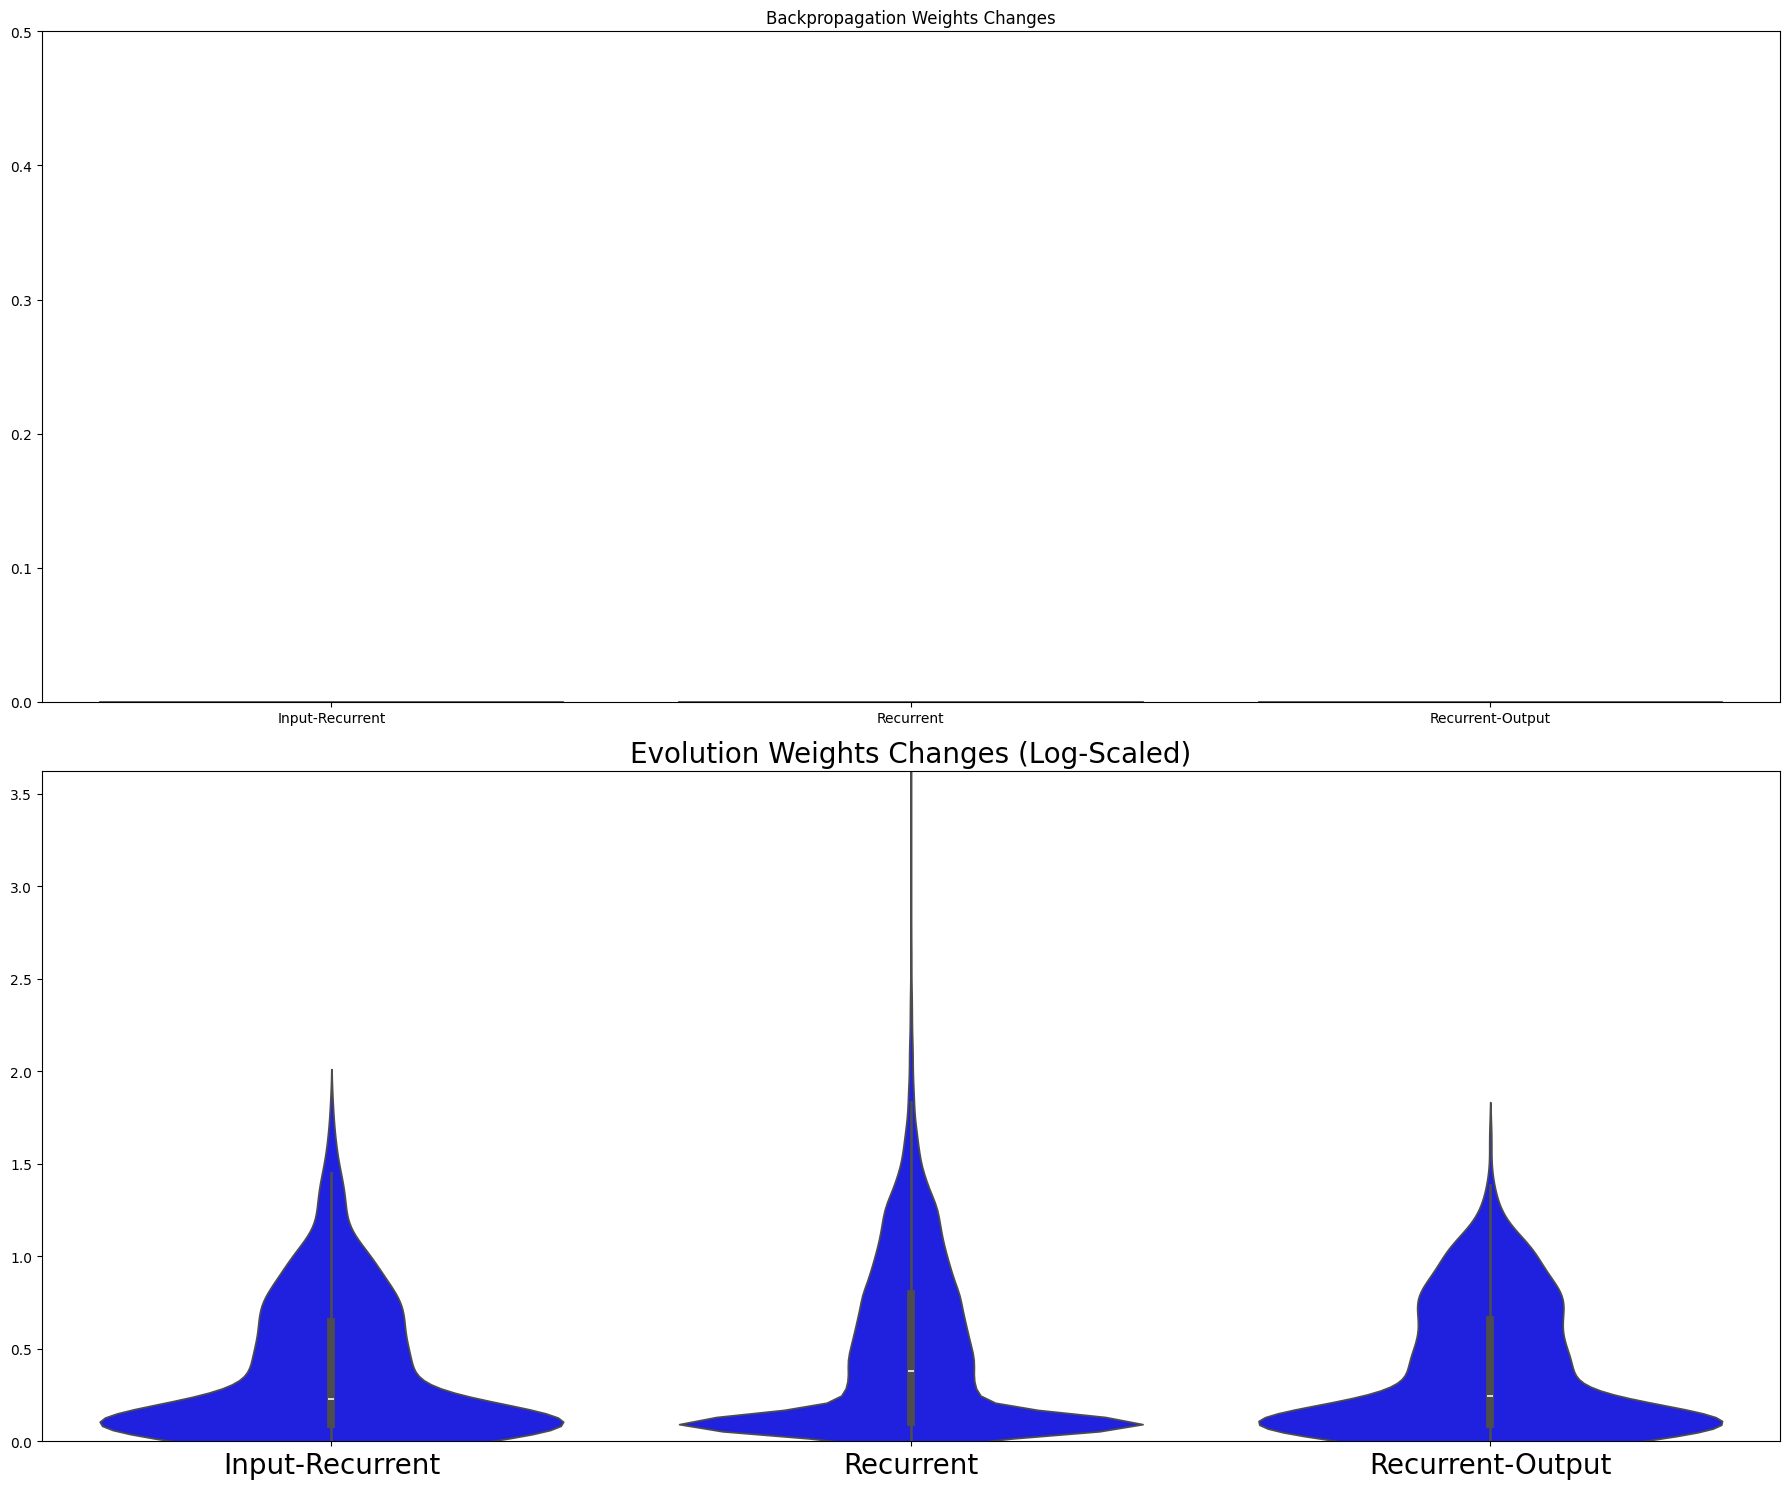

In [75]:
# generates violin plots to compare the weight changes of the backpropagation model and the evolution model

# Helper functions for weight analysis
def get_layer_weights(models, average=True):
    layer_weights = {
        'input_recurrent': [],
        'recurrent': [],
        'recurrent_output': []
    }
    
    for model in models:
        input_recurrent_weights = model.l1.weight.data.cpu().numpy()
        recurrent_weights = model.rlif1.recurrent.weight.data.cpu().numpy()
        recurrent_output_weights = model.l2.weight.data.cpu().numpy()
        
        layer_weights['input_recurrent'].append(input_recurrent_weights)
        layer_weights['recurrent'].append(recurrent_weights)
        layer_weights['recurrent_output'].append(recurrent_output_weights)
    
    if average:
        avg_weights = {
            'input_recurrent': np.mean(layer_weights['input_recurrent'], axis=0),
            'recurrent': np.mean(layer_weights['recurrent'], axis=0),
            'recurrent_output': np.mean(layer_weights['recurrent_output'], axis=0)
        }
        return avg_weights
    else:
        return {
            'input_recurrent': layer_weights['input_recurrent'][0],
            'recurrent': layer_weights['recurrent'][0],
            'recurrent_output': layer_weights['recurrent_output'][0]
        }

def compute_weight_differences(initial_weights, final_weights):
    weight_diffs = {}

    for layer in initial_weights.keys():
        # Compute absolute differences without filtering out zero weights
        differences = np.abs(final_weights[layer] - initial_weights[layer])
        weight_diffs[layer] = differences.flatten()  # Flatten to get a 1D array

    return weight_diffs

def plot_violin_plots(weight_changes_backprop, weight_changes_evolution):
    fig, axs = plt.subplots(2, 1, figsize=(18, 15))

    # Apply log transformation to highlight extreme values
    for layer in weight_changes_backprop:
        weight_changes_backprop[layer] = np.log1p(weight_changes_backprop[layer])
        weight_changes_evolution[layer] = np.log1p(weight_changes_evolution[layer])

    # Combine all data to find the global min and max for consistent y-axis limits
    all_data_backprop = np.concatenate([
        weight_changes_backprop['input_recurrent'],
        weight_changes_backprop['recurrent'],
        weight_changes_backprop['recurrent_output']
    ])
    all_data_evolution = np.concatenate([
        weight_changes_evolution['input_recurrent'],
        weight_changes_evolution['recurrent'],
        weight_changes_evolution['recurrent_output']
    ])
    y_max = max(np.max(all_data_backprop), np.max(all_data_evolution))

    # Plot for Backpropagation model
    sns.violinplot(data=[
        weight_changes_backprop['input_recurrent'],
        weight_changes_backprop['recurrent'],
        weight_changes_backprop['recurrent_output']
    ], ax=axs[0], palette=['red', 'red', 'red'])
    axs[0].set_title('Backpropagation Weights Changes')
    axs[0].set_xticks([0, 1, 2])
    axs[0].set_xticklabels(['Input-Recurrent', 'Recurrent', 'Recurrent-Output'])
    axs[0].set_ylim(0,0.5)

    # Plot for Evolution model
    sns.violinplot(data=[
        weight_changes_evolution['input_recurrent'],
        weight_changes_evolution['recurrent'],
        weight_changes_evolution['recurrent_output']
    ], ax=axs[1], palette=['blue', 'blue', 'blue'])
    axs[1].set_title('Evolution Weights Changes (Log-Scaled)', fontsize=20)
    axs[1].set_xticks([0, 1, 2])
    axs[1].set_xticklabels(['Input-Recurrent', 'Recurrent', 'Recurrent-Output'], fontsize=20)
    # axs.ticklabel_format(useOffset=False)
    axs[1].set_ylim(0, y_max)
    plt.tight_layout()
    plt.show()

In [ ]:

# Get initial and final weights for backpropagation model (single model, no averaging)
initial_weights_backprop = get_layer_weights([backprop_model], average=False)
final_weights_backprop = get_layer_weights([backprop_model], average=False)

# Get initial weights for the initial population and final weights for the best model from evolution
initial_weights_evolution = get_layer_weights(initial_models)
final_weights_evolution = get_layer_weights([best_model])

# Compute weight differences
weight_changes_backprop = compute_weight_differences(initial_weights_backprop, final_weights_backprop)
weight_changes_evolution = compute_weight_differences(initial_weights_evolution, final_weights_evolution)

# Plot violin plots
plot_violin_plots(weight_changes_backprop, weight_changes_evolution)

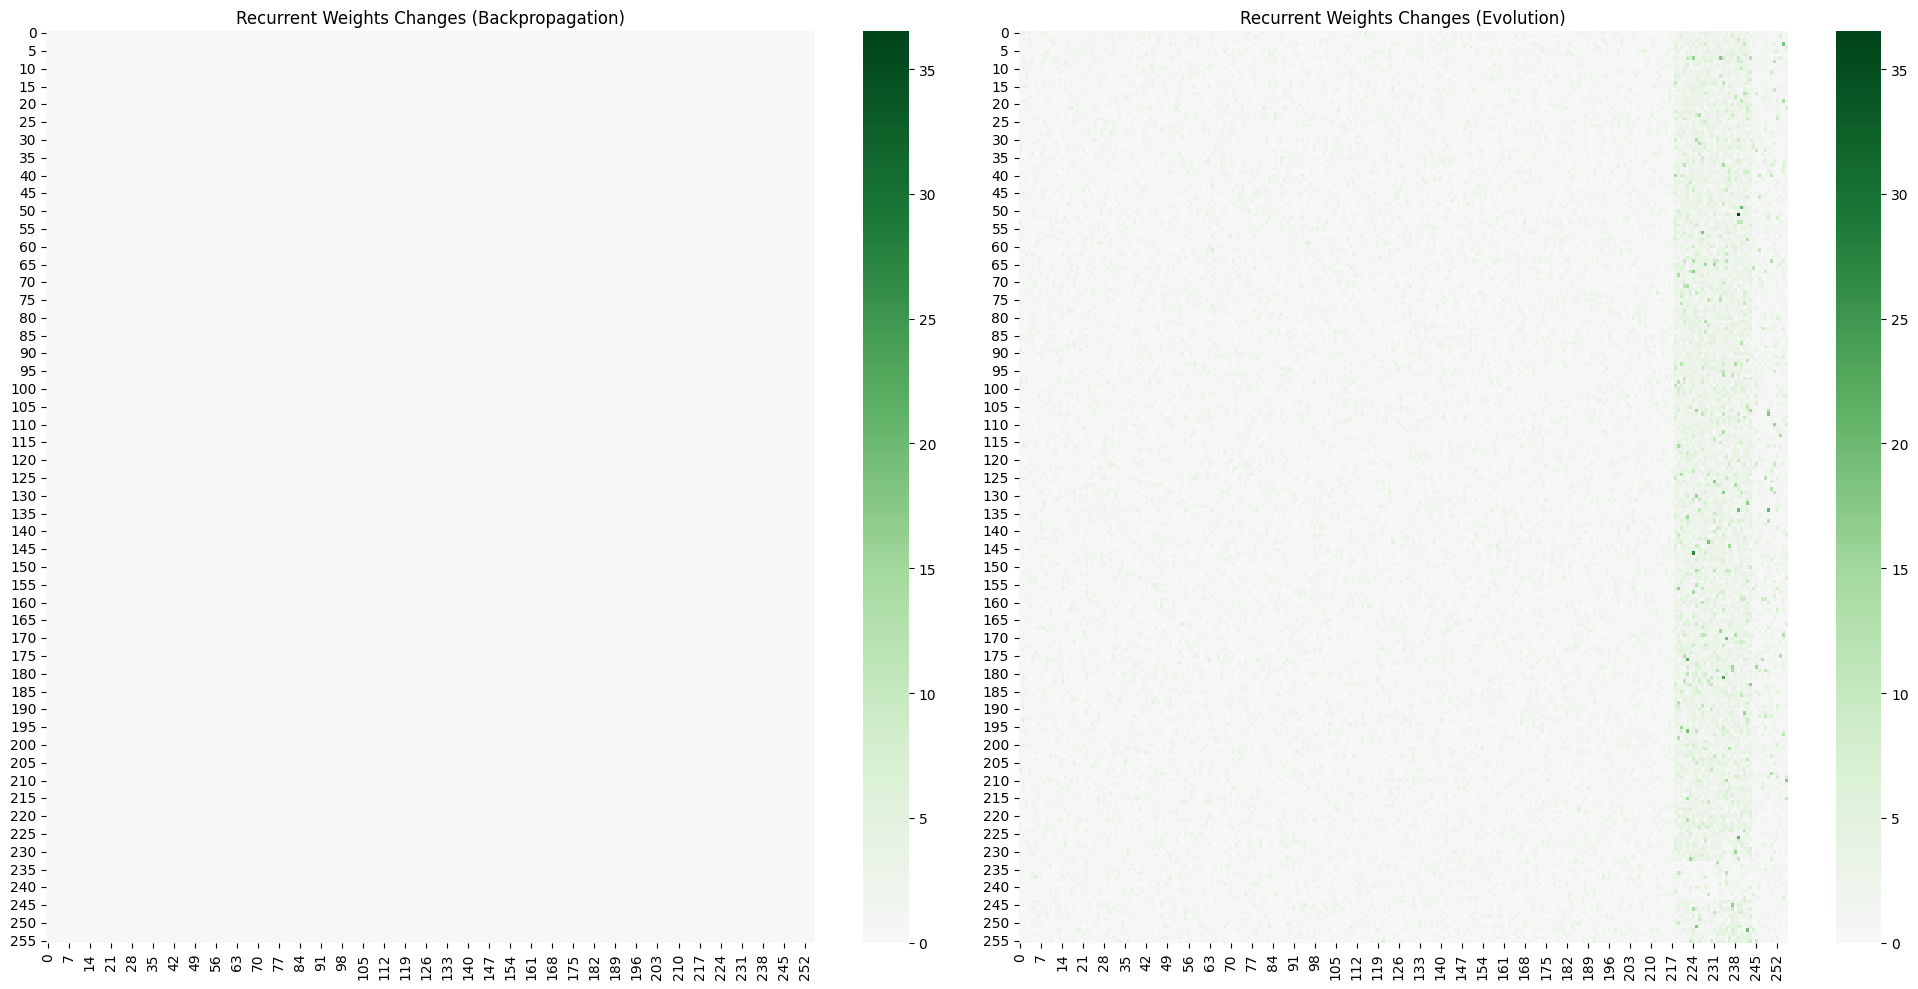

In [49]:
# Plot heatmaps to visualize the weight changes in the recurrent layer for both models
def plot_heatmaps(weight_changes_backprop, weight_changes_evolution):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Use absolute value for heatmap scale
    all_data = np.concatenate([
        weight_changes_backprop['recurrent'].flatten(),
        weight_changes_evolution['recurrent'].flatten()
    ])
    vmin = 0
    vmax = np.max(all_data)

    # Heatmap for Backpropagation model
    sns.heatmap(weight_changes_backprop['recurrent'], ax=axs[0], vmin=vmin, vmax=vmax, cmap="PRGn", center=0)
    axs[0].set_title('Recurrent Weights Changes (Backpropagation)')

    # Heatmap for Evolution model
    sns.heatmap(weight_changes_evolution['recurrent'], ax=axs[1], vmin=vmin, vmax=vmax, cmap="PRGn", center=0)
    axs[1].set_title('Recurrent Weights Changes (Evolution)')

    plt.tight_layout()
    plt.show()



# Plot heatmaps
plot_heatmaps(weight_changes_backprop, weight_changes_evolution)

In [ ]:
# heatmap to visualize the connectivity changes across layers
def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot heatmaps for each layer
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    sns.heatmap(weight_diffs['input_recurrent'], ax=axs[0], cmap="seismic", center=0 )
    axs[0].set_title('Difference in Input to Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent'], ax=axs[1], cmap="seismic", center=0)
    axs[1].set_title('Difference in Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent_output'], ax=axs[2], cmap="seismic", center=0)
    axs[2].set_title('Difference in Recurrent to Output Weights')
    
    plt.tight_layout()
    plt.show()


best_perf = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, final_population)


In [ ]:
# line plot to visualize the weight changes across layers for the best model from evolution
def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot the differences for each layer
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    
    # Input to recurrent layer weights differences
    axs[0].plot(weight_diffs['input_recurrent'].flatten(), label='Weight Differences')
    axs[0].set_title('Difference in Input to Recurrent Weights')
    axs[0].set_xlabel('Weight Index')
    axs[0].set_ylabel('Weight Difference')
    axs[0].legend()

    
    # Recurrent layer weights differences
    axs[1].plot(weight_diffs['recurrent'].flatten(), label='Weight Differences')
    axs[1].set_title('Difference in Recurrent Weights')
    axs[1].set_xlabel('Weight Index')
    axs[1].set_ylabel('Weight Difference')
    axs[1].legend()
  
    
    # Recurrent to output layer weights differences
    axs[2].plot(weight_diffs['recurrent_output'].flatten(), label='Weight Differences')
    axs[2].set_title('Difference in Recurrent to Output Weights')
    axs[2].set_xlabel('Weight Index')
    axs[2].set_ylabel('Weight Difference')
    axs[2].legend()
    
  
    plt.tight_layout()
    plt.show()


final_models = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, final_models)

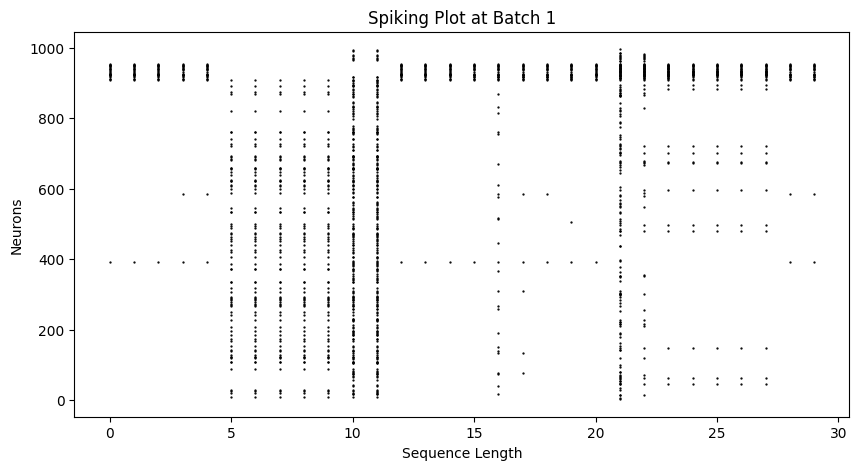

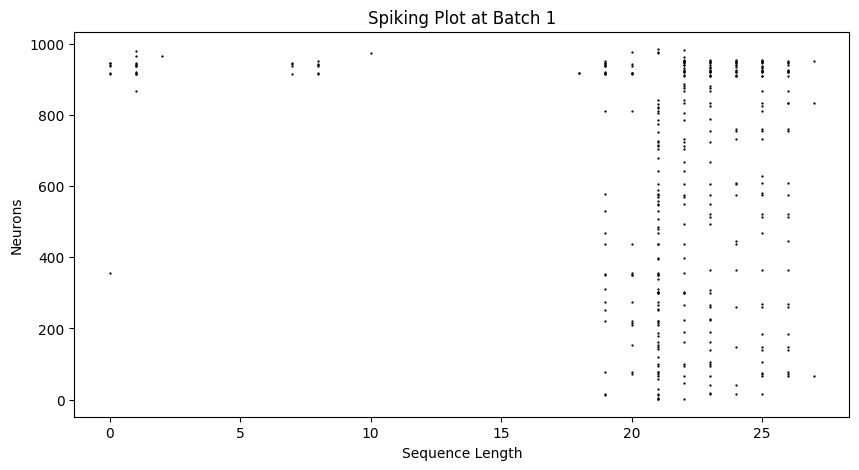

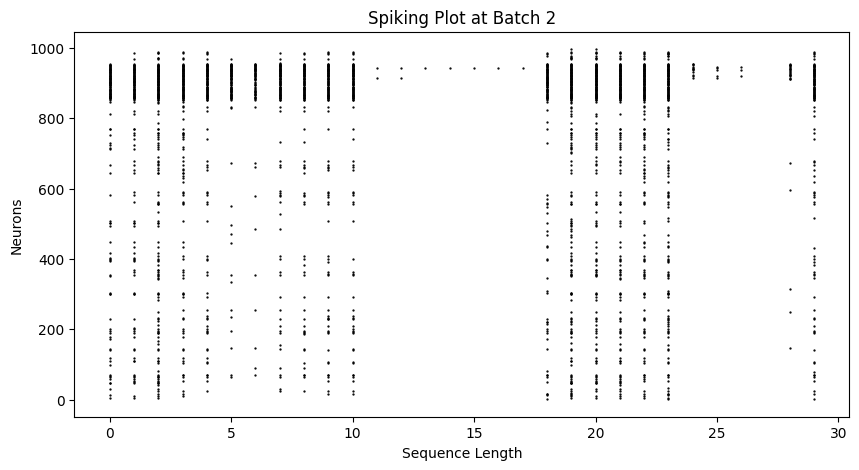

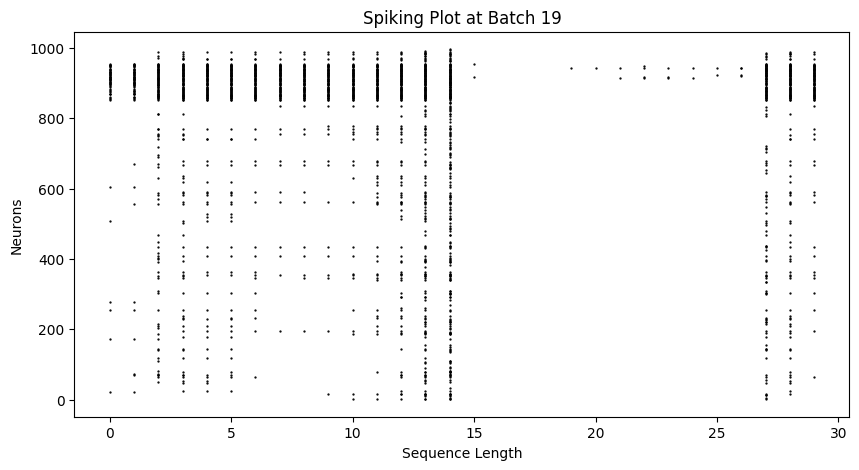

In [ ]:
# raster plots for the spiking activity of the best model from evolution
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spikes
    splt.raster(spk_tensor.T, ax=ax, s=0.4, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Sequence Length")
    ax.set_title(title)

    plt.show()

spikes_torch = torch.from_numpy(Ze_data['spikes'])
# spikes_numpy = spikes_torch.numpy()    
plot_spike_tensor(spikes_torch[0][1,:,:].T, 'Spiking Plot at Batch 1')
plot_spike_tensor(spikes_torch[0][9,:,:].T, 'Spiking Plot at Batch 1')
# plot_spike_tensor(spikes_torch[45].T, 'Spiking Neuron')
# plot_spike_tensor(spikes_torch[27].T, 'Spiking Plot at Batch 40')
plot_spike_tensor(spikes_torch[8][1,:,:].T, 'Spiking Plot at Batch 2')
plot_spike_tensor(spikes_torch[19][1,:,:].T, 'Spiking Plot at Batch 19')

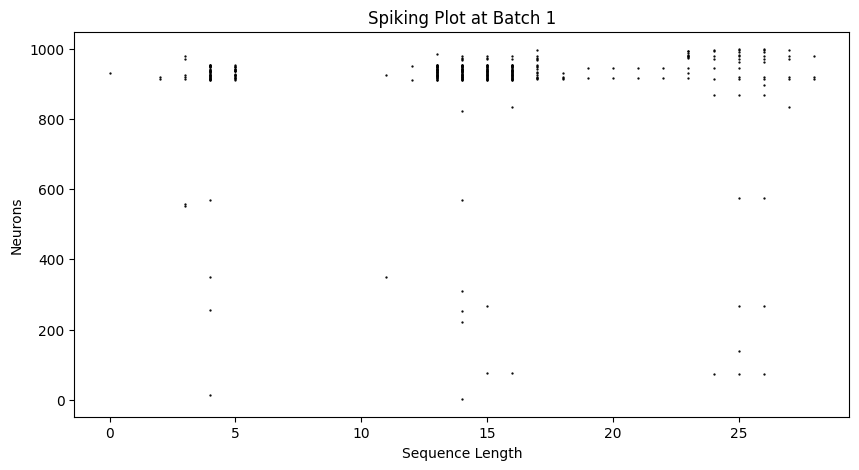

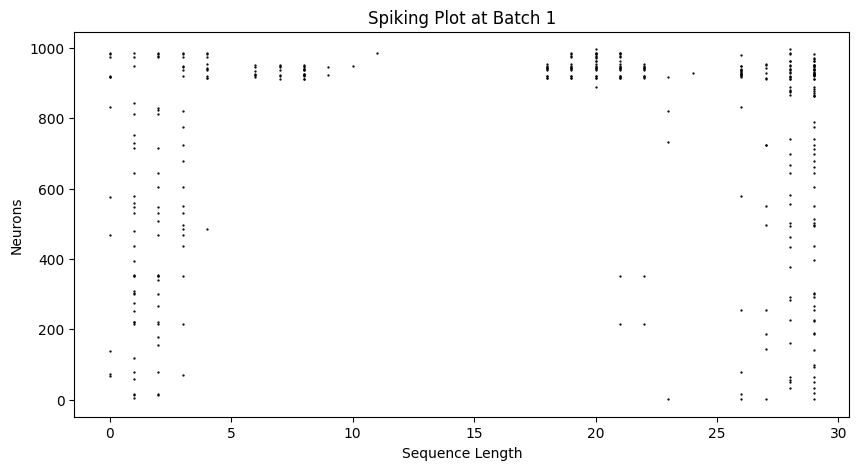

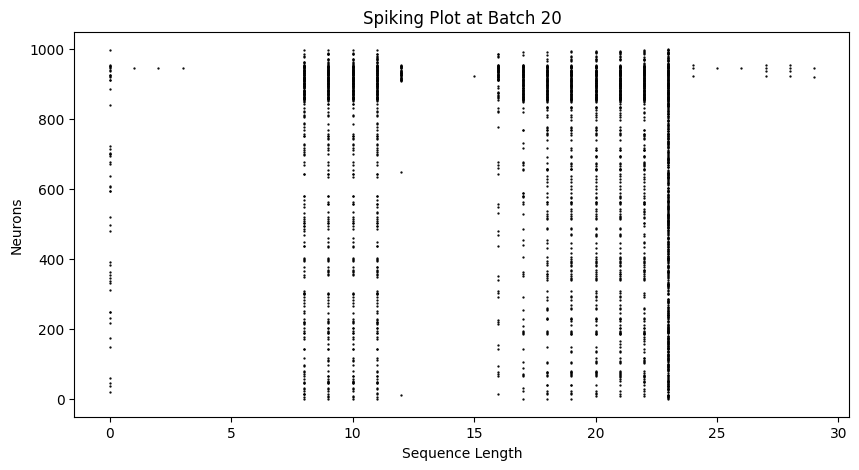

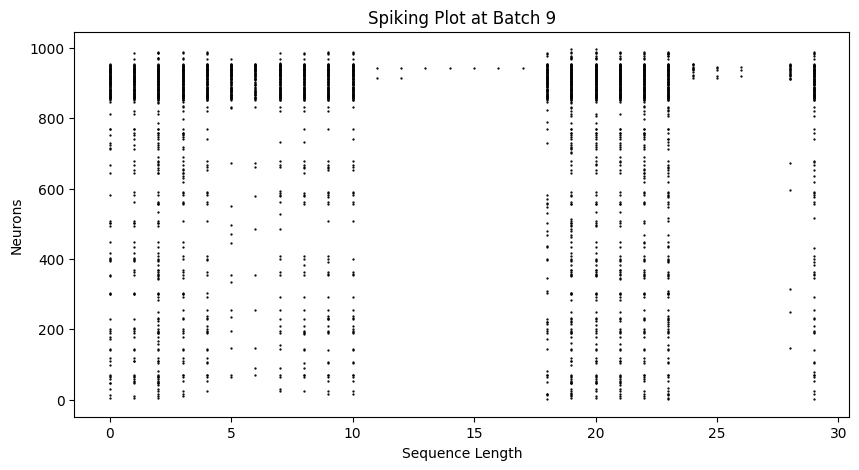

In [ ]:
epoch = 32
data = load_epoch_data(epoch)
plot_spike_tensor(spikes_torch[6][25,:,:].T, 'Spiking Plot at Batch 1')
plot_spike_tensor(spikes_torch[0][49,:,:].T, 'Spiking Plot at Batch 1')
# plot_spike_tensor(spikes_torch[45].T, 'Spiking Neuron')
# plot_spike_tensor(spikes_torch[27].T, 'Spiking Plot at Batch 40')
plot_spike_tensor(spikes_torch[2][1,:,:].T, 'Spiking Plot at Batch 20')
plot_spike_tensor(spikes_torch[8][1,:,:].T, 'Spiking Plot at Batch 9')